In [2]:

from analyze import analyze_data
from utils import RequestData
import json
from datetime import datetime
from zoneinfo import ZoneInfo

def get_performance(report):
    loadgen_data = report['loadgen_data']

    total_request_count = len(loadgen_data)
    no_response_count = 0
    error_count = 0
    requests = []
    for request_data in loadgen_data:
        if 'error' not in request_data.keys():
            request = RequestData.init_from_dict(request_data)
            requests.append(request)
            continue

        if request_data == {'error': 'No response!'}:
            no_response_count += 1
        else:
            error_count += 1

    ttft_attain_count = 0
    tbt_attain_count = 0
    total_attain_count = 0
    for request in requests:
        ttft_attain, tbt_attain = request.satisfy_SLO()
        if ttft_attain:
            ttft_attain_count += 1
        
        if tbt_attain:
            tbt_attain_count += 1
        
        if ttft_attain and tbt_attain:
            total_attain_count += 1

    ttft_attain_rate = ttft_attain_count / total_request_count
    tbt_attain_rate = tbt_attain_count / total_request_count
    total_attain_rate = total_attain_count / total_request_count

    # print(f"Among {total_request_count} requests, {ttft_attain_count} attain TTFT, {tbt_attain_count} attain TBT, {total_attain_count} attain total")
    # print(f"total attain rate: {total_attain_rate*100:.1f}%, TTFT attain rate: {ttft_attain_rate*100:.1f}%, TBT attain rate: {tbt_attain_rate*100:.1f}%")
    return ttft_attain_rate, tbt_attain_rate, total_attain_rate


def get_locality(report):
    same_node_count = 0
    cross_node_count = 0
    loadgen_data = report['loadgen_data']
    total_request_count = len(loadgen_data)
    for request_data in loadgen_data:
        if 'error' in request_data.keys():
            continue
        request = RequestData.init_from_dict(request_data)
        if request.pd_same_node == 0:
            cross_node_count += 1
        else:
            same_node_count += 1
    return same_node_count, cross_node_count, total_request_count

In [3]:

run_log_dirs = [
    "/mnt/network_drive/lrq/logs/logs_2025-07-24-00-44-59/run_0",
    "/mnt/network_drive/lrq/logs/logs_2025-07-27-15-22-38/run_0",
    "/mnt/network_drive/lrq/logs/logs_2025-07-27-15-41-18/run_0",
    "/mnt/network_drive/lrq/logs/logs_2025-07-27-16-00-15/run_0",
    "/mnt/network_drive/lrq/logs/logs_2025-07-27-16-11-31/run_0",
] 
ttft_attain_rates = []
tbt_attain_rates = []
total_attain_rates = []
locality_rates = []

for run_log_dir in run_log_dirs:
    GRAN = "30s"
    metrics_list = []
    report_file_path = analyze_data(run_log_dir, metrics_list)
    with open(report_file_path, 'r') as f:
        report = json.load(f)

    ttft_attain_rate, tbt_attain_rate, total_attain_rate = get_performance(report)
    same_node_count, cross_node_count, total_request_count = get_locality(report)

    print(f"For run_log_dir: {run_log_dir}, TTFT attain rate: {ttft_attain_rate*100:.1f}%, TBT attain rate: {tbt_attain_rate*100:.1f}%, total attain rate: {total_attain_rate*100:.1f}%")
    print(f"For run_log_dir: {run_log_dir}, same node count: {same_node_count}, cross node count: {cross_node_count}, total request count: {total_request_count}, locality rate: {(same_node_count / total_request_count)*100:.2f}%")

    ttft_attain_rates.append(ttft_attain_rate)
    tbt_attain_rates.append(tbt_attain_rate)
    total_attain_rates.append(total_attain_rate)
    locality_rates.append(same_node_count / (same_node_count + cross_node_count))

QUERY_PROM is 0, skipping Prometheus startup.
Running Python app...
query_metrics_list: []
params_list: []
For run_log_dir: /mnt/network_drive/lrq/logs/logs_2025-07-24-00-44-59/run_0, TTFT attain rate: 34.8%, TBT attain rate: 99.7%, total attain rate: 34.8%
For run_log_dir: /mnt/network_drive/lrq/logs/logs_2025-07-24-00-44-59/run_0, same node count: 1906, cross node count: 5, total request count: 1917, locality rate: 99.43%
QUERY_PROM is 0, skipping Prometheus startup.
Running Python app...
query_metrics_list: []
params_list: []
For run_log_dir: /mnt/network_drive/lrq/logs/logs_2025-07-27-15-22-38/run_0, TTFT attain rate: 17.6%, TBT attain rate: 63.4%, total attain rate: 17.6%
For run_log_dir: /mnt/network_drive/lrq/logs/logs_2025-07-27-15-22-38/run_0, same node count: 1152, cross node count: 64, total request count: 1897, locality rate: 60.73%
QUERY_PROM is 0, skipping Prometheus startup.
Running Python app...
query_metrics_list: []
params_list: []
For run_log_dir: /mnt/network_drive/

Text(0, 0.5, 'TBT Attain Rate%')

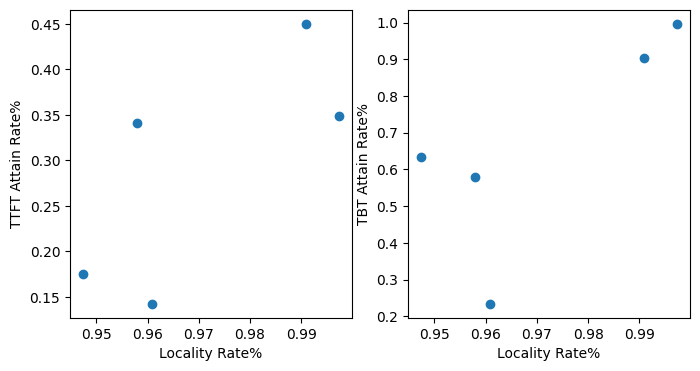

In [4]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(1, 2, figsize=(8, 4))
axes[0].scatter(locality_rates, ttft_attain_rates, marker='o', label='TTFT Attain Rate')
axes[0].set_xlabel('Locality Rate%')
axes[0].set_ylabel('TTFT Attain Rate%')
axes[1].scatter(locality_rates, tbt_attain_rates, marker='o', label='TBT Attain Rate')
axes[1].set_xlabel('Locality Rate%')
axes[1].set_ylabel('TBT Attain Rate%')

In [5]:

# run_log_dirs = [
#     "/mnt/network_drive/lrq/logs/logs_2025-07-27-19-57-37/run_0",
#     "/mnt/network_drive/lrq/logs/logs_2025-07-27-19-57-37/run_1",
#     "/mnt/network_drive/lrq/logs/logs_2025-07-27-19-57-37/run_2",
#     "/mnt/network_drive/lrq/logs/logs_2025-07-27-20-08-33/run_0",
#     "/mnt/network_drive/lrq/logs/logs_2025-07-27-20-08-33/run_1",
#     "/mnt/network_drive/lrq/logs/logs_2025-07-27-20-08-33/run_2",
# ] 

# run_log_dirs = [
#     "/mnt/network_drive/lrq/logs/logs_2025-07-27-20-18-34/run_0",
#     "/mnt/network_drive/lrq/logs/logs_2025-07-27-20-18-34/run_1",
#     "/mnt/network_drive/lrq/logs/logs_2025-07-27-20-18-34/run_2",
#     "/mnt/network_drive/lrq/logs/logs_2025-07-27-20-26-30/run_0",
#     "/mnt/network_drive/lrq/logs/logs_2025-07-27-20-26-30/run_1",
#     "/mnt/network_drive/lrq/logs/logs_2025-07-27-20-26-30/run_2",
# ]

# run_log_dirs = [
#     "/mnt/network_drive/lrq/logs/logs_2025-07-28-11-22-32/run_0",
#     "/mnt/network_drive/lrq/logs/logs_2025-07-28-11-22-32/run_1",
#     "/mnt/network_drive/lrq/logs/logs_2025-07-28-11-22-32/run_2",
#     "/mnt/network_drive/lrq/logs/logs_2025-07-28-11-22-32/run_3",
#     "/mnt/network_drive/lrq/logs/logs_2025-07-28-11-22-32/run_4",
#     "/mnt/network_drive/lrq/logs/logs_2025-07-28-11-22-32/run_5",
# ]

# run_log_dirs = [
#     "/mnt/network_drive/lrq/logs/logs_2025-07-28-14-30-39/run_0",
#     "/mnt/network_drive/lrq/logs/logs_2025-07-28-14-30-39/run_1",
#     "/mnt/network_drive/lrq/logs/logs_2025-07-28-14-30-39/run_2",
#     "/mnt/network_drive/lrq/logs/logs_2025-07-28-14-30-39/run_3",
#     "/mnt/network_drive/lrq/logs/logs_2025-07-28-14-30-39/run_4",
#     "/mnt/network_drive/lrq/logs/logs_2025-07-28-14-30-39/run_5",
# ]
run_log_dirs = [
    "/mnt/network_drive/lrq/logs/logs_2025-07-28-17-04-12/run_0",
    "/mnt/network_drive/lrq/logs/logs_2025-07-28-17-04-12/run_1",
    "/mnt/network_drive/lrq/logs/logs_2025-07-28-17-04-12/run_2",
    "/mnt/network_drive/lrq/logs/logs_2025-07-28-17-04-12/run_3",
    "/mnt/network_drive/lrq/logs/logs_2025-07-28-17-04-12/run_4",
]
ttft_attain_rates = []
tbt_attain_rates = []
total_attain_rates = []
locality_rates = []

for run_log_dir in run_log_dirs:
    metrics_list = []
    report_file_path = analyze_data(run_log_dir, metrics_list)
    with open(report_file_path, 'r') as f:
        report = json.load(f)

    ttft_attain_rate, tbt_attain_rate, total_attain_rate = get_performance(report)
    same_node_count, cross_node_count, total_request_count = get_locality(report)

    print(f"For run_log_dir: {run_log_dir}, TTFT attain rate: {ttft_attain_rate*100:.1f}%, TBT attain rate: {tbt_attain_rate*100:.1f}%, total attain rate: {total_attain_rate*100:.1f}%")
    print(f"For run_log_dir: {run_log_dir}, same node count: {same_node_count}, cross node count: {cross_node_count}, total request count: {total_request_count}, locality rate: {(same_node_count / total_request_count)*100:.2f}%")

    ttft_attain_rates.append(ttft_attain_rate*100)
    tbt_attain_rates.append(tbt_attain_rate*100)
    total_attain_rates.append(total_attain_rate*100)
    locality_rates.append((same_node_count / (same_node_count+cross_node_count))*100)

QUERY_PROM is 0, skipping Prometheus startup.
Running Python app...
query_metrics_list: []
params_list: []
For run_log_dir: /mnt/network_drive/lrq/logs/logs_2025-07-28-17-04-12/run_0, TTFT attain rate: 50.4%, TBT attain rate: 61.7%, total attain rate: 50.4%
For run_log_dir: /mnt/network_drive/lrq/logs/logs_2025-07-28-17-04-12/run_0, same node count: 1179, cross node count: 28, total request count: 1949, locality rate: 60.49%
QUERY_PROM is 0, skipping Prometheus startup.
Running Python app...
query_metrics_list: []
params_list: []
For run_log_dir: /mnt/network_drive/lrq/logs/logs_2025-07-28-17-04-12/run_1, TTFT attain rate: 7.9%, TBT attain rate: 18.8%, total attain rate: 7.9%
For run_log_dir: /mnt/network_drive/lrq/logs/logs_2025-07-28-17-04-12/run_1, same node count: 311, cross node count: 52, total request count: 1886, locality rate: 16.49%
QUERY_PROM is 0, skipping Prometheus startup.
Running Python app...
query_metrics_list: []
params_list: []
For run_log_dir: /mnt/network_drive/lr

Text(0, 0.5, 'TBT Attain Rate%')

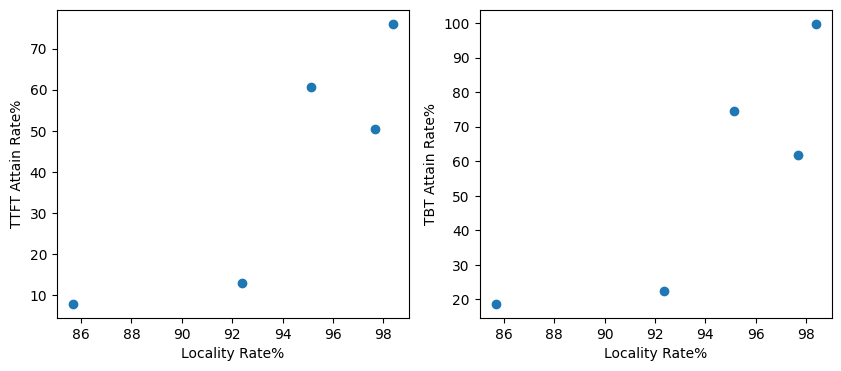

In [6]:

import matplotlib.pyplot as plt
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
axes[0].scatter(locality_rates, ttft_attain_rates, marker='o', label='TTFT Attain Rate')
axes[0].set_xlabel('Locality Rate%')
axes[0].set_ylabel('TTFT Attain Rate%')
axes[1].scatter(locality_rates, tbt_attain_rates, marker='o', label='TBT Attain Rate')
axes[1].set_xlabel('Locality Rate%')
axes[1].set_ylabel('TBT Attain Rate%')